In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Unbalanced Classes

## Introduction: cancer detection case study

You are a data scientist at a medical research company and are tasked to build an image classifier that analyzes brain scans. Your goal is to train a machine to recognize brain cancer from the image of a scan. You work hard, engineer clever features, train your model and obtain a 90% accuracy score. At this point you are extremely happy and present your results to the boss. However, she replies your model is terrible. Why is that?

One thing you did not notice is that in the dataset you received, 90% of the images come from healthy brains. This means that your sophisticated model is no better than saying that every brain in the dataset is healthy (baseline).

This is a typical example of class imbalance.

![Brain scan imbalance](images/brain_scan_imbalance.png)
[](https://en.wikipedia.org/wiki/Radiology#/media/File:Brain_CT_scan.jpg)
[](https://en.wikipedia.org/wiki/Brain_tumor#/media/File:Hirnmetastase_MRT-T1_KM.jpg)

## Definition and common scenarios for unbalanced data

In a binary classification problem, data is said to be unbalanced if there is a large difference in the number of samples representing each class. This situation is very common, arising each time we are dealing with an anomalous rare event. Besides cancer screening, other examples may include:
- **fraud detection**: there are fewer fraudulent than legitimate transactions on a website
- **churn prediction**: of the whole customer base, only few customers are churning
- **genetic screening**: a specific genetic mutation can be very rare compared to normal
- **text categorization**: in a corpus of documents, only a few deal with a specific topic

When two classes are balanced, a model predicting only one class for every input will be 50% accurate, i.e. will be correct every other time. As the imbalance increases, a model predicting the majority class will appear to be more and more accurate, which could have serious consequences if not properly diagnosed and handled. 

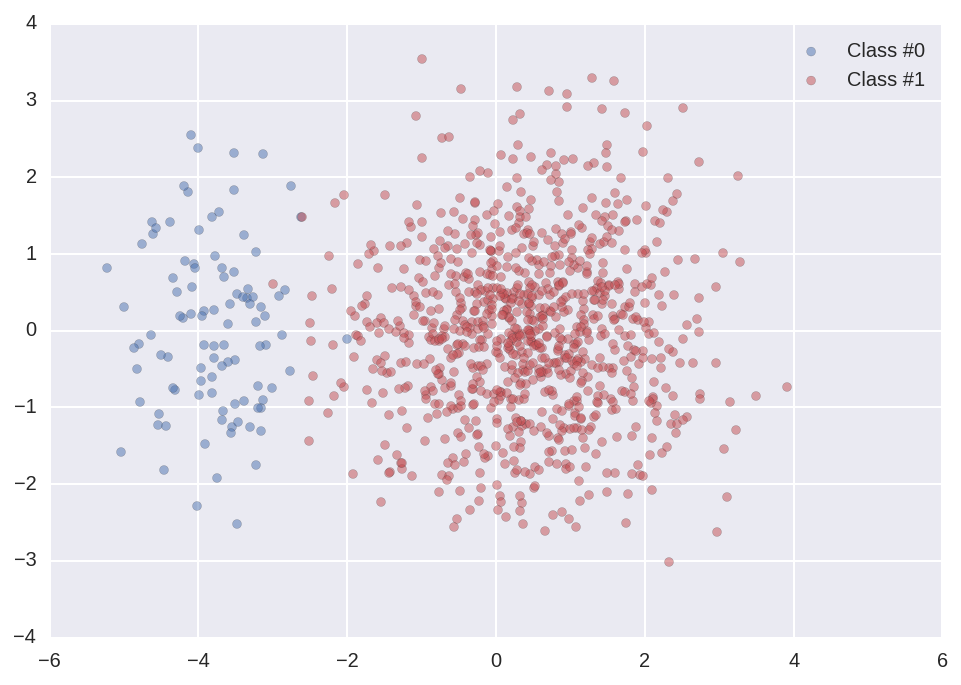

In [2]:
# https://github.com/glemaitre/UnbalancedDataset/blob/master/notebook/Notebook_UnbalancedDataset.ipynb
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification


# Generate some data
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=1000, random_state=10)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
x_vis = pca.fit_transform(X)

# Plot the original data
# Plot the two classes
palette = sns.color_palette()
plt.scatter(x_vis[y==0, 0], x_vis[y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor='#262626', facecolor=palette[0], linewidth=0.15)
plt.scatter(x_vis[y==1, 0], x_vis[y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor='#262626', facecolor=palette[2], linewidth=0.15)

plt.legend()
plt.show()

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MajorityPredictor(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.majority_class = 0
    
    def fit(self, X, y):
        from collections import Counter
        self.majority_class = max(Counter(y))
        return self
    
    def predict(self, X):
        l = len(X)
        return [self.majority_class]*l

In [4]:
mp = MajorityPredictor()
mp.fit(X, y)
mp.score(X, y)

0.90000000000000002

## Simple techniques to deal with unbalanced data

There are several techniques to deal with unbalanced classes.

### Collect more data
Can you collect more samples of the minority class in order to have a better representation of it?
This may not be possible in fields like fraud detection, but could potentially happen in the cases of text or image classification.

### Use a different performance metric
Accuracy is only one of the possible metrics we introduced to evaluate the performance of a model. As seen in Module 2, there are other metrics that offer a more detailed view on the actual performance of the model. For example: precision, recall and F1-score offer insights on what kind of error we are incurring.

**Question**: 

1. In the above case of the brain scans, what will be the precision and recall of the naive model that predicts healthy brain at 100% of the time?

In [5]:
from sklearn.metrics import classification_report
ypred = mp.predict(X)
print classification_report(y, ypred)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       100
          1       0.90      1.00      0.95       900

avg / total       0.81      0.90      0.85      1000



/opt/conda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


A more detailed view of the predictions for each class can be obtained by looking at the confusion matrix, which displays the actual number of cases that are predicted in to be in each class.

In [6]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y, ypred),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

,class 0 pred,class 1 pred
class 0 actual,0,100
class 1 actual,0,900


## Undersampling
When lots of data is present, a simple and effective strategy to deal with imbalance is to simply discard a random subset of the majority class, effectively undersampling it.
- Pros: quick, easy to implement, lower load on model training because of less data
- Cons: potentially losing important information

Besides random undersampling, there are several other non-random ways to effectively undersample the majority class. The interested reader is referred to the references mentioned [here](https://github.com/fmfn/UnbalancedDataset).

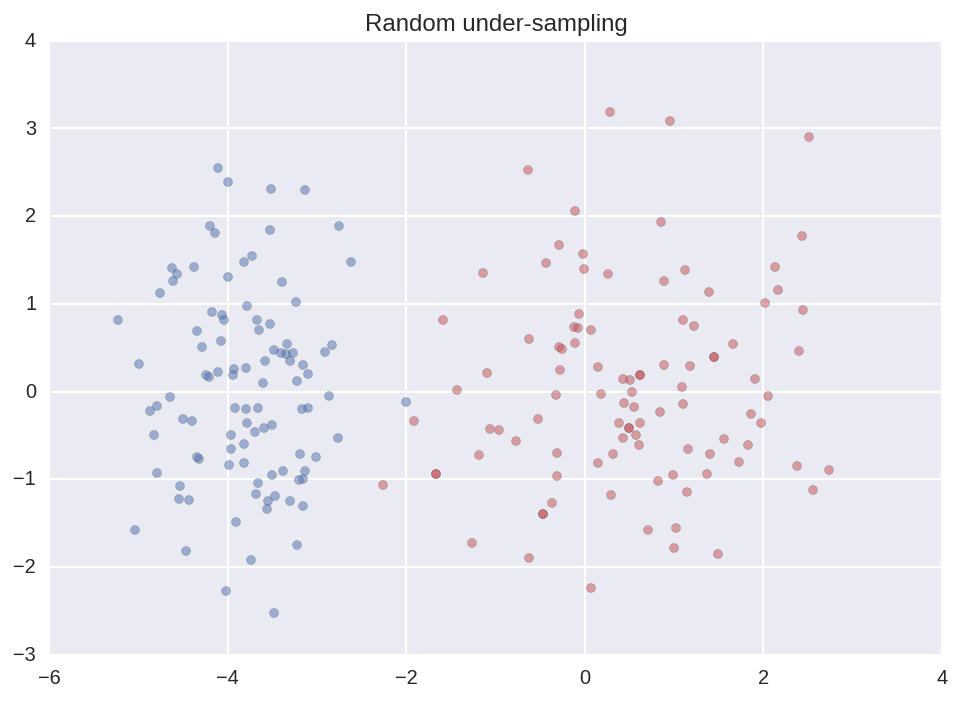

In [7]:
from unbalanced_dataset import UnderSampler

US = UnderSampler(verbose=False, random_state=0)
usx, usy = US.fit_transform(X, y)
usx_vis = pca.transform(usx)

plt.scatter(usx_vis[usy==0, 0], usx_vis[usy==0, 1], label="Class #0", alpha=0.5,
            facecolor=palette[0], linewidth=0.15)
plt.scatter(usx_vis[usy==1, 0], usx_vis[usy==1, 1], label="Class #1", alpha=0.5,
            facecolor=palette[2], linewidth=0.15)
plt.title('Random under-sampling')

## Oversampling
Similarly, using more copies of the data in the minority class can also be an effective strategy.
- Pros: retaining all available information
- Cons: more data, not necessarily more information if minority class is not well represented

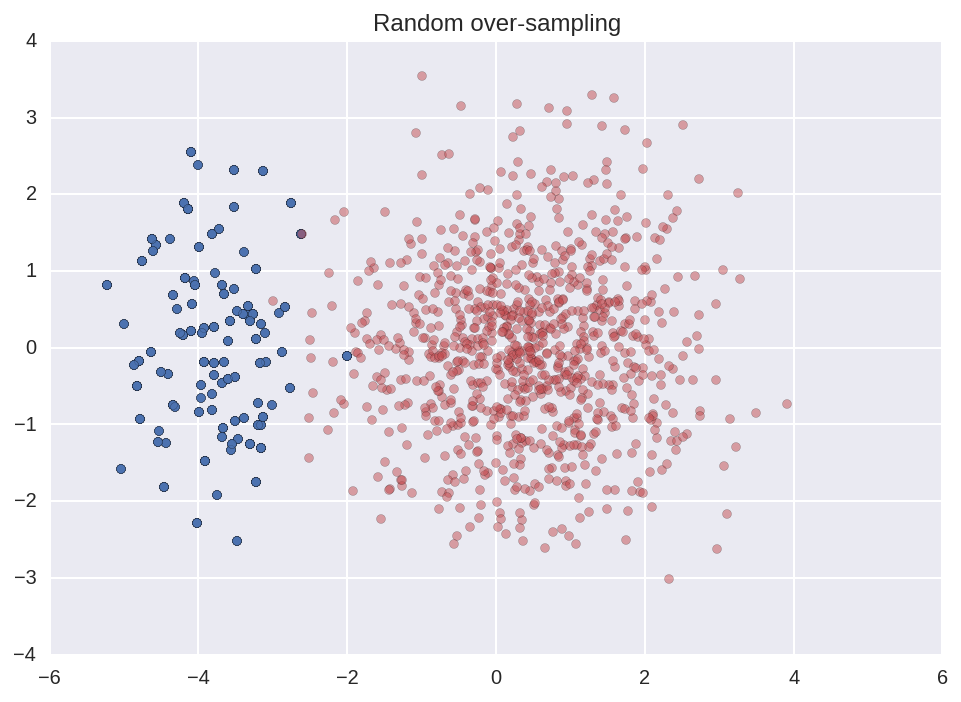

In [8]:
from unbalanced_dataset import OverSampler
ratio = float(np.count_nonzero(y==1)) / float(np.count_nonzero(y==0))

OS = OverSampler(ratio=ratio, verbose=False, random_state=0)
osx, osy = OS.fit_transform(X, y)
osx_vis = pca.transform(osx)

plt.scatter(osx_vis[osy==0, 0], osx_vis[osy==0, 1], label="Class #0", alpha=0.5,
            facecolor=palette[0], linewidth=0.15)
plt.scatter(osx_vis[osy==1, 0], osx_vis[osy==1, 1], label="Class #1", alpha=0.5,
            facecolor=palette[2], linewidth=0.15)
plt.title('Random over-sampling')

## Synthetic data augmentation
There are several techniques to create synthetic samples starting from the minority class. The most common are [SMOTE, Synthetic Minority Over-sampling Technique](http://www.jair.org/papers/paper953.html), and its variants. SMOTE creates synthetic samples from the minority class using a nearest neighbor technique. The algorithm selects two or more similar instances (using a distance measure) and it creates a new sample whose features are a linear combination of the neighbors features, with a random mixing parameter.

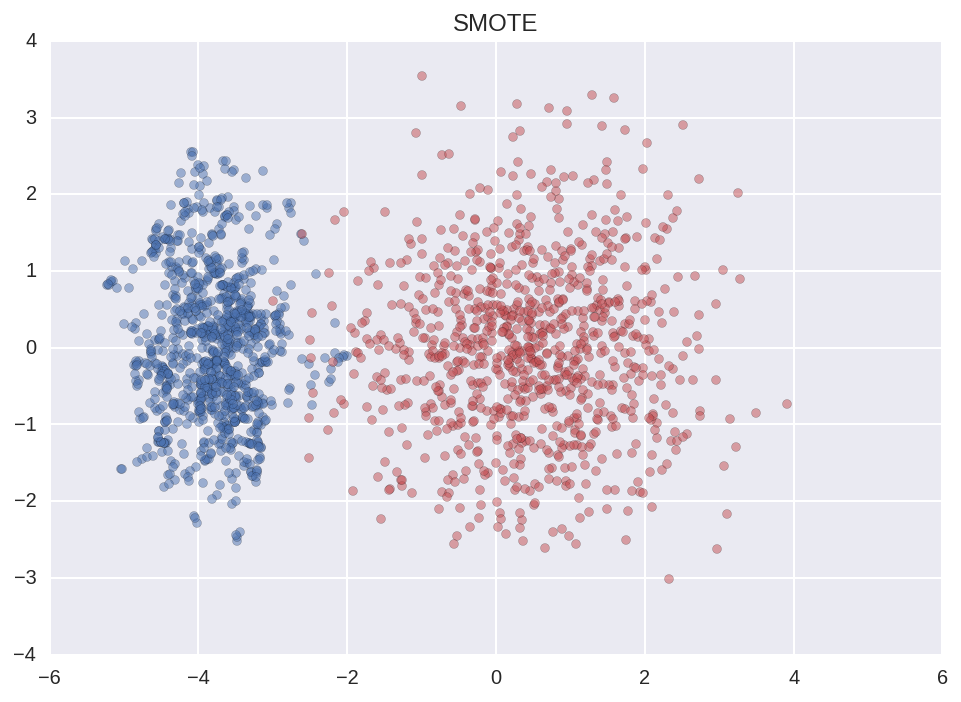

In [9]:
from unbalanced_dataset import SMOTE

smote = SMOTE(ratio=ratio, verbose=False, kind='regular', random_state=0)
smox, smoy = smote.fit_transform(X, y)
smox_vis = pca.transform(smox)
plt.scatter(smox_vis[smoy==0, 0], smox_vis[smoy==0, 1], label="Class #0", alpha=0.5,
            facecolor=palette[0], linewidth=0.15)
plt.scatter(smox_vis[smoy==1, 0], smox_vis[smoy==1, 1], label="Class #1", alpha=0.5,
            facecolor=palette[2], linewidth=0.15)
plt.title('SMOTE')

## Additional approaches

In addition to using a metric sensitive to imbalance and to resampling the dataset in the attempt to rebalance the class ratio, it is possible to modify the model too. Options include:

- **Use ROC curve** to evaluate how precision and recall are traded depending on the value of a threshold, if the classifier allows it. See [here for an example](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#example-model-selection-plot-roc-py).

- **Penalizing the majority class**: use a model that allows to set different weights for the different classes. See [here for an example](http://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html).

- **Anomaly/outlier detection**: consider the problem as an anomaly detection problem and use the majority class to train a model. See [here for a couple of examples](http://scikit-learn.org/stable/modules/outlier_detection.html).


Other ideas can be found [here](https://www.quora.com/In-classification-how-do-you-handle-an-unbalanced-training-set).

## Train/Test split with unbalanced data
Any operation that alters the balance of the classes by adding samples for the minority class should only be performed on the training set. The test set should be left untouched, or possibly downsampled, but not oversampled. In particular, train/test split should never be performed *after* rebalancing.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=3)

estimator = KNeighborsClassifier(10)

estimator.fit(X_train, y_train)
ypred = estimator.predict(X_test)
print classification_report(y_test, ypred)
pd.DataFrame(confusion_matrix(y_test, ypred),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

             precision    recall  f1-score   support

          0       1.00      0.74      0.85        66
          1       0.96      1.00      0.98       434

avg / total       0.97      0.97      0.96       500



,class 0 pred,class 1 pred
class 0 actual,49,17
class 1 actual,0,434


In [12]:
smote = SMOTE(ratio=ratio, verbose=False, kind='regular', random_state=0)
smox, smoy = smote.fit_transform(X_train, y_train)

estimator.fit(smox, smoy)
ypred = estimator.predict(X_test)
print classification_report(y_test, ypred)
pd.DataFrame(confusion_matrix(y_test, ypred),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])


             precision    recall  f1-score   support

          0       0.84      1.00      0.91        66
          1       1.00      0.97      0.98       434

avg / total       0.98      0.97      0.97       500



,class 0 pred,class 1 pred
class 0 actual,66,0
class 1 actual,13,421


In [13]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()

estimator.fit(X_train, y_train)
ypred = estimator.predict(X_test)
print classification_report(y_test, ypred)
pd.DataFrame(confusion_matrix(y_test, ypred),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

             precision    recall  f1-score   support

          0       1.00      0.95      0.98        66
          1       0.99      1.00      1.00       434

avg / total       0.99      0.99      0.99       500



,class 0 pred,class 1 pred
class 0 actual,63,3
class 1 actual,0,434


In [14]:
smox, smoy = smote.fit_transform(X_train, y_train)

estimator.fit(smox, smoy)
ypred = estimator.predict(X_test)
print classification_report(y_test, ypred)
pd.DataFrame(confusion_matrix(y_test, ypred),
             index = ['class 0 actual', 'class 1 actual'],
             columns = ['class 0 pred', 'class 1 pred'])

             precision    recall  f1-score   support

          0       1.00      0.98      0.99        66
          1       1.00      1.00      1.00       434

avg / total       1.00      1.00      1.00       500



,class 0 pred,class 1 pred
class 0 actual,65,1
class 1 actual,0,434


**Question**:

1. what could happen if oversampling was done before train/test split?

## Probabilities with unbalanced data

Modifying the balance of the training dataset will affect the probabilities distributions learned by the estimator. We need to keep this in mind if we are predicting probabilities and not just the class.


In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
estimator = LogisticRegression()

estimator.fit(X_train, y_train)
(100.0*estimator.predict_proba(X_test)).round(1)[-10:]

array([[   0.1,   99.9],
       [   0. ,  100. ],
       [   0.3,   99.7],
       [   8.7,   91.3],
       [  98.2,    1.8],
       [  99.1,    0.9],
       [   0. ,  100. ],
       [  12.7,   87.3],
       [   0.4,   99.6],
       [   0. ,  100. ]])

In [17]:
estimator.fit(smox, smoy)
(100.0*estimator.predict_proba(X_test)).round(1)[-10:]

array([[   0. ,  100. ],
       [   0. ,  100. ],
       [   0.1,   99.9],
       [  14. ,   86. ],
       [  99.8,    0.2],
       [  99.9,    0.1],
       [   0. ,  100. ],
       [  18.2,   81.8],
       [   0.2,   99.8],
       [   0. ,  100. ]])

## The python Unbalanced Data package

The [unbalanced dataset python package](https://github.com/fmfn/UnbalancedDataset) implements several techniques for rebalancing an unbalanced dataset.

See [this notebook](https://github.com/fmfn/UnbalancedDataset/blob/master/notebook/Notebook_UnbalancedDataset.ipynb) for examples of the implementation.

See further notes [here](http://stats.stackexchange.com/questions/131255/class-imbalance-in-supervised-machine-learning)

### Exit Tickets

1. What are some common causes for data imbalance?
1. How can one deal with unbalanced dataset? List several ways with pros and cons
1. What's wrong with resampling all the data before train/test split?
1. How is Cross Validation performed in the case of unbalanced classes?

### Spoilers

### Answers

#### Precision/Recall
1. for the healthy class, precision is 90%, recall is 100%. For the cancer class, precision and recall are both 0%.

#### Resampling before train/test split
1. copies of the same data point could be present in both the training and test set, increasing the risk of overfitting due to information leakage.

*Copyright &copy; 2015 The Data Incubator.  All rights reserved.*